In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


In [2]:
# Load the saved day 7 features
loaded_day7_feats = torch.load('combined_cond7.pt')

# Load the saved day 10 features
loaded_day10_feats = torch.load('combined_cond10.pt')

# Verify the shapes
print(f"Loaded Day 7 Features Shape: {loaded_day7_feats.shape}")
print(f"Loaded Day 10 Features Shape: {loaded_day10_feats.shape}")


Loaded Day 7 Features Shape: torch.Size([780, 512])
Loaded Day 10 Features Shape: torch.Size([780, 512])


C:\Users\k54739\AppData\Local\Temp\ipykernel_6740\3131424418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_day7_feats = torch.load('combined_cond7.pt')
C:\Users

In [3]:
train_day7_feats = loaded_day7_feats 
train_day10_feats = loaded_day10_feats 

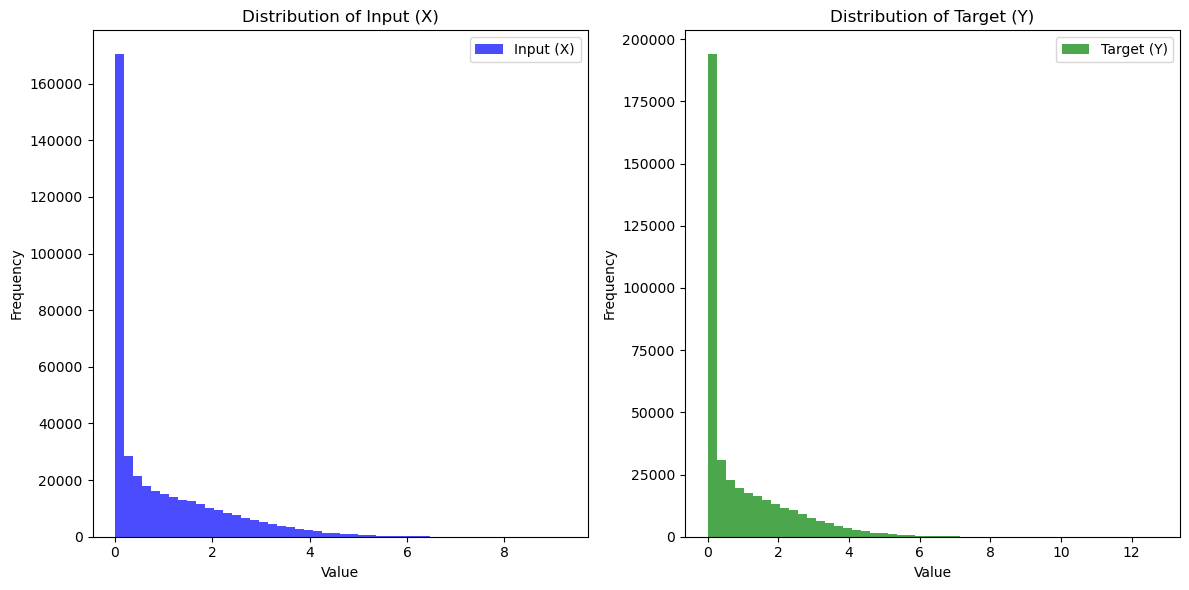

Input (X): Mean=0.9166, Std=1.1727
Target (Y): Mean=0.9179, Std=1.2474


In [4]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
train_day7_feats_flat = train_day7_feats.flatten().cpu().numpy()
train_day10_feats_flat = train_day10_feats.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={train_day7_feats.mean():.4f}, Std={train_day7_feats.std():.4f}")
print(f"Target (Y): Mean={train_day10_feats.mean():.4f}, Std={train_day10_feats.std():.4f}")


In [5]:
# Convert PyTorch tensor to NumPy array
train_day7_feats_numpy = train_day7_feats.numpy()
train_day10_feats_numpy = train_day10_feats.numpy()

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize separate MinMaxScaler for day7 and day10
scaler_day7 = MinMaxScaler()
scaler_day10 = MinMaxScaler()

# Fit and transform the train_day7_feats
train_day7_feats_minmaxed = scaler_day7.fit_transform(train_day7_feats_numpy)
print(train_day7_feats_minmaxed.shape)
# Get min and max values for day7
min_values_day7 = scaler_day7.data_min_
max_values_day7 = scaler_day7.data_max_

print(min_values_day7.shape)
print(max_values_day7.shape)
#print("Min values for day7:", min_values_day7)
#print("Max values for day7:", max_values_day7)

# Fit and transform the train_day10_feats (target)
train_day10_feats_minmaxed = scaler_day10.fit_transform(train_day10_feats_numpy)
print(train_day10_feats_minmaxed.shape)
# Get min and max values for day10
min_values_day10 = scaler_day10.data_min_
max_values_day10 = scaler_day10.data_max_

print(min_values_day10.shape)
print(max_values_day10.shape)
#print("Min values for day10:", min_values_day10)
#print("Max values for day10:", max_values_day10)

# Convert the scaled data back to PyTorch tensors (optional)
train_day7_feats_minmaxed = torch.tensor(train_day7_feats_minmaxed)
train_day10_feats_minmaxed = torch.tensor(train_day10_feats_minmaxed)


(780, 512)
(512,)
(512,)
(780, 512)
(512,)
(512,)


In [7]:
import joblib

# Save the scalers to disk
joblib.dump(scaler_day7, 'scaler_day7.pkl')
joblib.dump(scaler_day10, 'scaler_day10.pkl')

print("Scalers saved!")


Scalers saved!


In [8]:
type(train_day7_feats_minmaxed)

torch.Tensor

# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
train_day7_feats_minmaxed, day7_min, day7_max = min_max_scaling(train_day7_feats)
train_day10_feats_minmaxed, day10_min, day10_max = min_max_scaling(train_day10_feats)

# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={train_day7_feats_minmaxed.min():.4f}, Max={train_day7_feats_minmaxed.max():.4f}")
print(f"Target (Y): Min={train_day10_feats_minmaxed.min():.4f}, Max={train_day10_feats_minmaxed.max():.4f}")



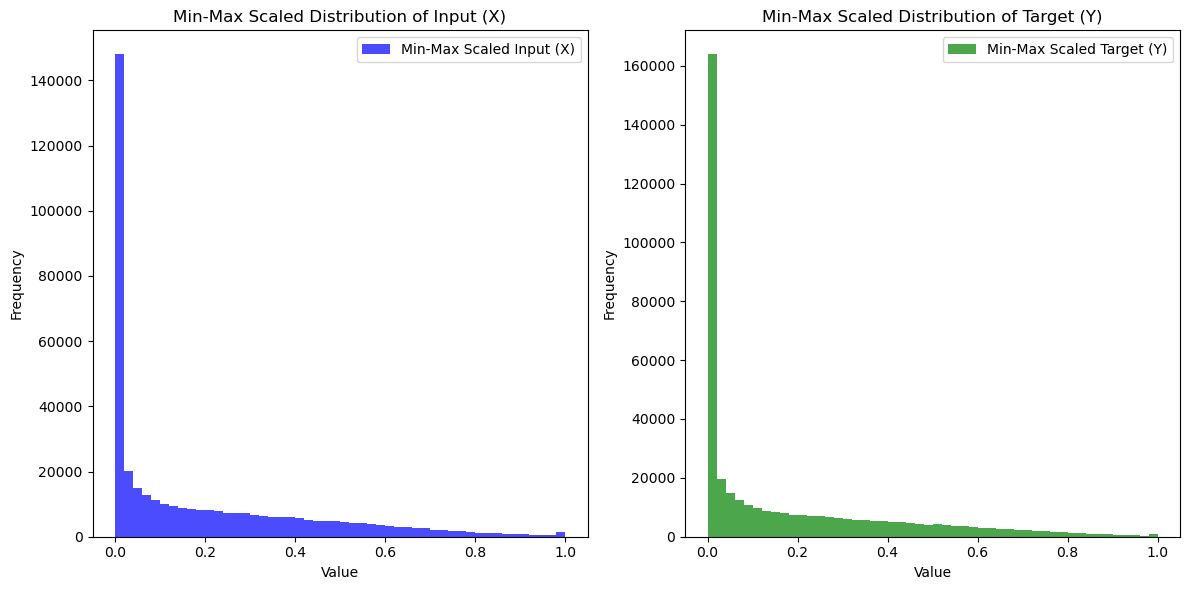

In [7]:
import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
train_day7_feats_minmaxed_flat = train_day7_feats_minmaxed.flatten().cpu().numpy()
train_day10_feats_minmaxed_flat = train_day10_feats_minmaxed.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after Min-Max scaling
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_minmaxed_flat, bins=50, color='blue', alpha=0.7, label='Min-Max Scaled Input (X)')
plt.title('Min-Max Scaled Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after Min-Max scaling
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_minmaxed_flat, bins=50, color='green', alpha=0.7, label='Min-Max Scaled Target (Y)')
plt.title('Min-Max Scaled Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# regression model

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
        # Skip connection to stabilize training
        self.skip = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.main(x) + self.skip(x)  # Residual learning

In [30]:
#simplifeid autoencoder

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16),  # Bottleneck = 8
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z) + x  # Skip connection to aid reconstruction

In [8]:
#complicated autoencoder

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
20,10

10,6

6,3

3,6

6,10
10,20

(10, 20)

In [9]:
model = FeaturePredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

In [11]:
from torch.utils.data import TensorDataset

optimizer_class = torch.optim.Adam



In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch


In [13]:

class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after the last validation loss improvement.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_epochs = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_epochs = 0
        else:
            self.no_improvement_epochs += 1
            if self.no_improvement_epochs >= self.patience:
                self.early_stop = True


def cross_validate_with_early_stopping(
    model_class, dataset, criterion, optimizer_class, num_epochs=50, n_splits=5, patience=10, device='cuda'
):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize the model, optimizer, and early stopping for this fold
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        early_stopping = EarlyStopping(patience=patience)

        # Training and validation loop
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for batch_inputs, batch_targets in train_loader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

                # Forward pass
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                train_loss += loss.item()

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader)
            history['train_loss'].append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_inputs, batch_targets in val_loader:
                    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

            print(f"Epoch [{epoch + 1}/{num_epochs}] Fold {fold + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold + 1}")
                break

        # Save the best model for this fold
        best_models.append(model.state_dict())
        histories.append(history)

    return histories, best_models



In [14]:
# MIN MAX
dataset = TensorDataset(train_day7_feats_minmaxed, train_day10_feats_minmaxed)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=2000,
    patience=500
)


Fold 1/5
Epoch [1/2000] Fold 1, Train Loss: 0.0913, Val Loss: 0.0712
Epoch [2/2000] Fold 1, Train Loss: 0.0605, Val Loss: 0.0549
Epoch [3/2000] Fold 1, Train Loss: 0.0496, Val Loss: 0.0480
Epoch [4/2000] Fold 1, Train Loss: 0.0443, Val Loss: 0.0440
Epoch [5/2000] Fold 1, Train Loss: 0.0408, Val Loss: 0.0412
Epoch [6/2000] Fold 1, Train Loss: 0.0383, Val Loss: 0.0395
Epoch [7/2000] Fold 1, Train Loss: 0.0369, Val Loss: 0.0381
Epoch [8/2000] Fold 1, Train Loss: 0.0357, Val Loss: 0.0371
Epoch [9/2000] Fold 1, Train Loss: 0.0346, Val Loss: 0.0364
Epoch [10/2000] Fold 1, Train Loss: 0.0341, Val Loss: 0.0358
Epoch [11/2000] Fold 1, Train Loss: 0.0334, Val Loss: 0.0353
Epoch [12/2000] Fold 1, Train Loss: 0.0328, Val Loss: 0.0350
Epoch [13/2000] Fold 1, Train Loss: 0.0323, Val Loss: 0.0345
Epoch [14/2000] Fold 1, Train Loss: 0.0320, Val Loss: 0.0343
Epoch [15/2000] Fold 1, Train Loss: 0.0316, Val Loss: 0.0340
Epoch [16/2000] Fold 1, Train Loss: 0.0312, Val Loss: 0.0338
Epoch [17/2000] Fold 1, 

In [15]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.0272


In [16]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.0280
  Corresponding Training Loss = 0.0165
  Best Epoch = 282
Fold 2:
  Best Validation Loss = 0.0262
  Corresponding Training Loss = 0.0181
  Best Epoch = 219
Fold 3:
  Best Validation Loss = 0.0275
  Corresponding Training Loss = 0.0189
  Best Epoch = 183
Fold 4:
  Best Validation Loss = 0.0252
  Corresponding Training Loss = 0.0136
  Best Epoch = 649
Fold 5:
  Best Validation Loss = 0.0246
  Corresponding Training Loss = 0.0183
  Best Epoch = 199


In [19]:
import torch

# Save each fold's best model to the current directory
for i, model_state in enumerate(best_models):
    save_path = f'regression_fold_{i+1}.pth'  # Save in the current directory
    torch.save(model_state, save_path)

print("Models saved to the current directory.")


Models saved to the current directory.


In [17]:
def plot_loss_curves_separately(cv_histories):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['train_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['val_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


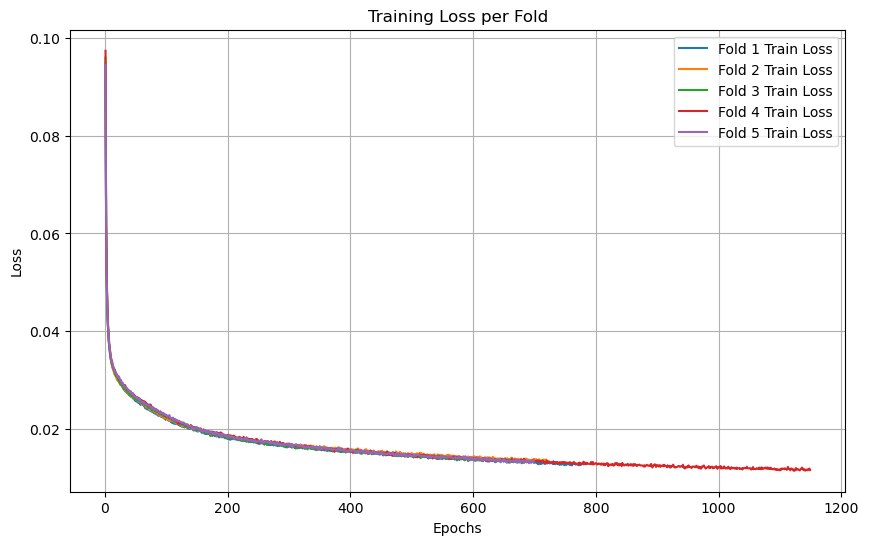

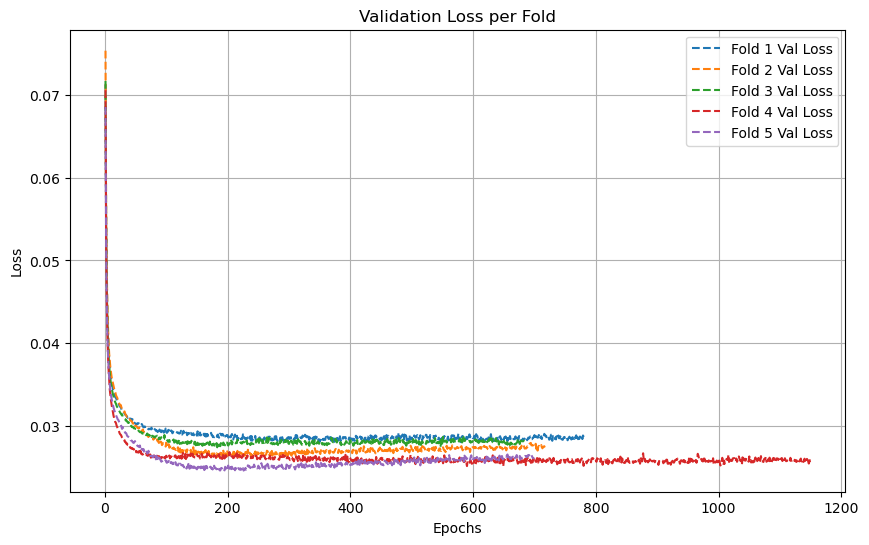

In [18]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)


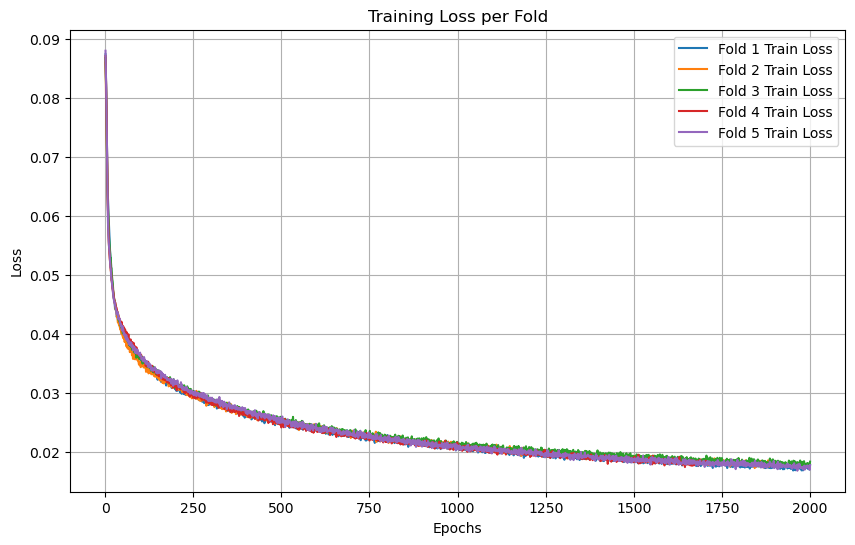

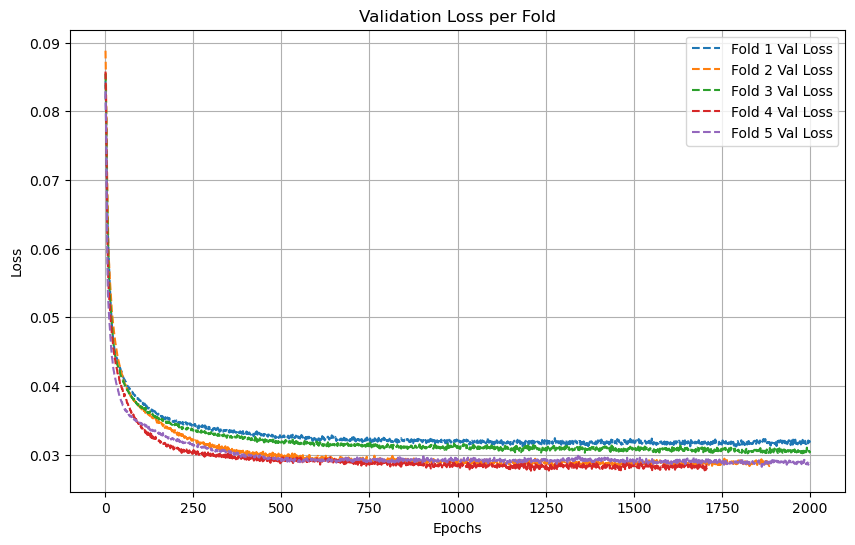

In [41]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)


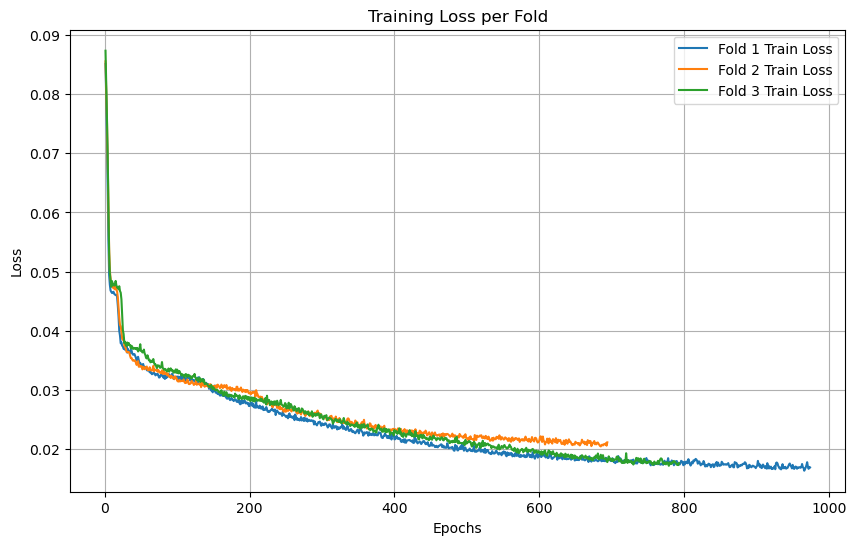

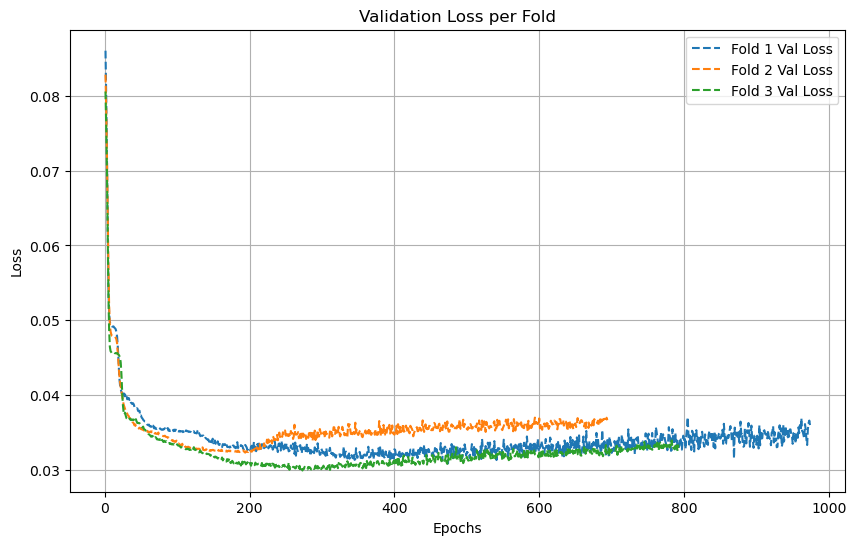

In [19]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)


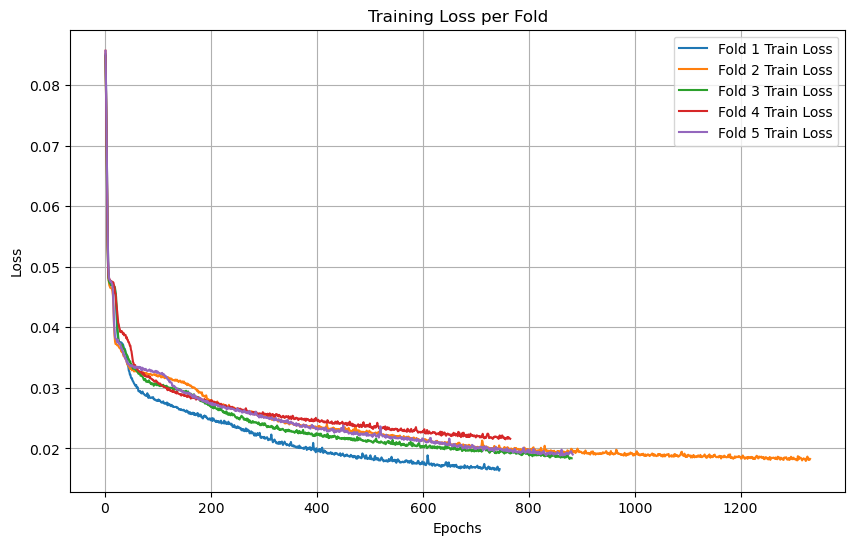

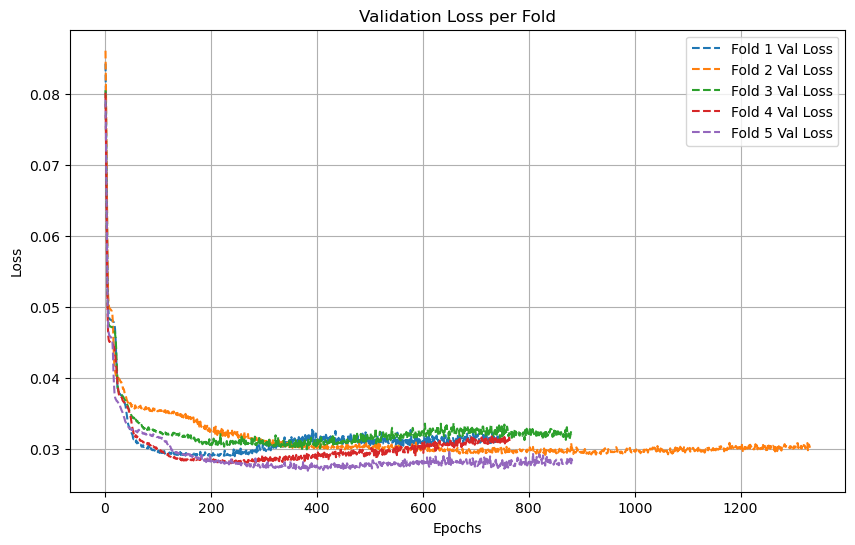

In [25]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)
